In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

In [2]:
df_train = pd.read_csv('AAPL.xls')
df_test = pd.read_csv('AAPL - Jan2018.xls')

In [3]:
df_test.sample()

,Date,Open
14,1/23/2018,177.300003


In [4]:
df_train.head()

,Date,Open
0,1/2/2013,79.117142
1,1/3/2013,78.268570
2,1/4/2013,76.709999
3,1/7/2013,74.571426
4,1/8/2013,75.601425


In [5]:
df_train.drop(['Date'], axis=1, inplace=True)
df_test.drop(['Date'], axis=1, inplace=True)

In [6]:
df_train.columns

Index(['Open'], dtype='object')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1259 non-null   float64
dtypes: float64(1)
memory usage: 10.0 KB


In [8]:
df_train.isnull().sum()

,0
Open,0


In [9]:
scaler = MinMaxScaler(feature_range = (0, 1))
#df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=list(df_train.columns))
df_train_scaled = scaler.fit_transform(df_train)
#df_train_scaled = pd.concat((df_train[['Date']],df_train_scaled_no_date), axis=1)
df_train_scaled

array([[0.19795893],
       [0.19086893],
       [0.17784673],
       ...,
       [0.95814041],
       [0.96566005],
       [0.96164958]])

In [10]:
df_train_scaled.shape

(1259, 1)

In [11]:
#df_train_tmp = df_train_scaled[['Date','Open']]

In [12]:
X_train = []
y_train = []
for i in range(60, 1259):
    X_train.append(df_train_scaled[i-60:i,0])
    y_train.append(df_train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
print("X_train : ",X_train.shape)
print("y_train : ",y_train.shape)

X_train :  (1199, 60)
y_train :  (1199, 1)


In [13]:
print("df_test:",df_test.shape)
print(df_test.columns)
print("df_train:",df_train.shape)
print(df_train.columns)

df_test: (20, 1)
Index(['Open'], dtype='object')
df_train: (1259, 1)
Index(['Open'], dtype='object')


In [14]:
df_total = pd.concat((df_test, df_train), axis=0, ignore_index=True)
print(df_total.shape)
print(df_total.columns)

(1279, 1)
Index(['Open'], dtype='object')


In [15]:
features_set_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
labels = y_train
print(features_set_train.shape)
print(labels.shape)

(1199, 60, 1)
(1199, 1)


# Model : LSTM

In [16]:
model_LSTM = Sequential()

model_LSTM.add(LSTM(units=300, return_sequences=True, input_shape=(features_set_train.shape[1], 1)))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=100, return_sequences=True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=100))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(Dense(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# compiling RNN
model_LSTM.compile(optimizer = "adam",
				loss = "mean_squared_error")

In [18]:
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 300)             │         362,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 603,301 (2.30 MB)

 Trainable params: 603,301 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# fitting the model
#model_LSTM.fit(features_set_train, labels, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - loss: 0.0636
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - loss: 0.0033
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - loss: 0.0026
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - loss: 0.0023
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - loss: 0.0024
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - loss: 0.0024
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - loss: 0.0024
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - loss: 0.0020
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - loss: 0.0021
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - loss: 0.0024
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - loss: 0.0019
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - loss: 0.0026
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - loss: 0.0019
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - loss: 0.0024
Epoch 15/100
38/38 ━━━━━━━━━━

In [21]:
import joblib

joblib.dump(model_LSTM, 'LSTM.joblib')

#loaded_model = joblib.load(filename)

['LSTM.joblib']

# Model : SimpleRNN

In [121]:
model_SimpleRNN = Sequential()

model_SimpleRNN.add(SimpleRNN(units=300, return_sequences=True, input_shape=(features_set_train.shape[1], 1)))

model_SimpleRNN.add(SimpleRNN(units=300, return_sequences=True))
model_SimpleRNN.add(Dropout(0.2))

model_SimpleRNN.add(SimpleRNN(units=100, return_sequences=True))
model_SimpleRNN.add(Dropout(0.2))

model_SimpleRNN.add(SimpleRNN(units=100, return_sequences=True))
model_SimpleRNN.add(Dropout(0.2))

#model_SimpleRNN.add(Dense(1, activation='relu'))
model_SimpleRNN.add(SimpleRNN(units = 1))

#model_LSTM.add(Dense(units = 1))

#adam = Adam(lr=0.0001)
model_SimpleRNN.compile(optimizer='adam', loss="mean_squared_error")


In [122]:
model_SimpleRNN.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_33 (SimpleRNN)            │ (None, 60, 300)             │          90,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_34 (SimpleRNN)            │ (None, 60, 300)             │         180,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 60, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_35 (SimpleRNN)            │ (None, 60, 100)             │          40,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_36 (SimpleRNN)            │ (None, 60, 100)             │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_37 (SimpleRNN)            │ (None, 1)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 331,202 (1.26 MB)

 Trainable params: 331,202 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
model_SimpleRNN.fit(features_set_train, labels, epochs = 100, batch_size = 16)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - loss: 0.2347
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - loss: 0.2468
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - loss: 0.2338
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - loss: 0.2261
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - loss: 0.2124
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - loss: 0.2156
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - loss: 0.2033
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - loss: 0.2001
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - loss: 0.2122
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - loss: 0.1722
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - loss: 0.1758
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - loss: 0.1721
Epoch 13/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - loss: 0.1531
Epoch 14/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - loss: 0.1401
Epoch 15/100
75/75 ━━━━━━━━━━

In [127]:
joblib.dump(model_SimpleRNN, 'SimpleRNN.joblib')

#loaded_model = joblib.load(filename)

['SimpleRNN.joblib']

# Model Evaluation

In [ ]:
model_LSTM = joblib.load('LSTM.joblib')
model_SimpleRNN = joblib.load('SimpleRNN.joblib')

In [128]:
df_total = pd.concat((df_train, df_test), axis=0)

In [129]:
test_inputs = df_total[len(df_total) - len(df_test) - 60:].values

In [130]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [131]:
#X_test = np.array(test_inputs)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [132]:
X_test = []
for i in range(60, 80):
    X_test.append(test_inputs[i-60:i, 0])

In [133]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [134]:
predictions_LSTM = model_LSTM.predict(X_test)
y_pred_LSTM = scaler.inverse_transform(predictions_LSTM)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [135]:
predictions_SimpleRNN = model_SimpleRNN.predict(X_test)
y_pred_SimpleRNN = scaler.inverse_transform(predictions_SimpleRNN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


In [136]:
print(y_pred_SimpleRNN.shape)
print(y_pred_LSTM.shape)
print(predictions_SimpleRNN.shape)

(20, 1)
(20, 1)
(20, 1)


In [137]:
df_test.iloc[5,0]

174.550003

In [138]:
for i in range(20):
  print(df_test.iloc[i,0],"\t",y_pred_LSTM[i],"\t",y_pred_SimpleRNN[i])


170.160004 	 [175.11641] 	 [108.48763]
172.529999 	 [175.13402] 	 [108.48763]
172.539993 	 [175.92815] 	 [108.48763]
173.440002 	 [176.73718] 	 [108.48763]
174.350006 	 [177.45256] 	 [108.48763]
174.550003 	 [178.152] 	 [108.48763]
173.160004 	 [178.65051] 	 [108.48763]
174.589996 	 [178.34863] 	 [108.48763]
176.179993 	 [178.36618] 	 [108.48763]
177.899994 	 [179.24176] 	 [108.48763]
176.149994 	 [180.81543] 	 [108.48764]
179.369995 	 [181.32233] 	 [108.48763]
178.610001 	 [182.25359] 	 [108.48763]
177.300003 	 [182.84186] 	 [108.48764]
177.300003 	 [182.5357] 	 [108.48763]
177.25 	 [181.99689] 	 [108.48764]
174.509995 	 [181.68184] 	 [108.48764]
172.0 	 [180.63826] 	 [108.48763]
170.160004 	 [178.73055] 	 [108.48763]
165.529999 	 [176.57433] 	 [108.48763]


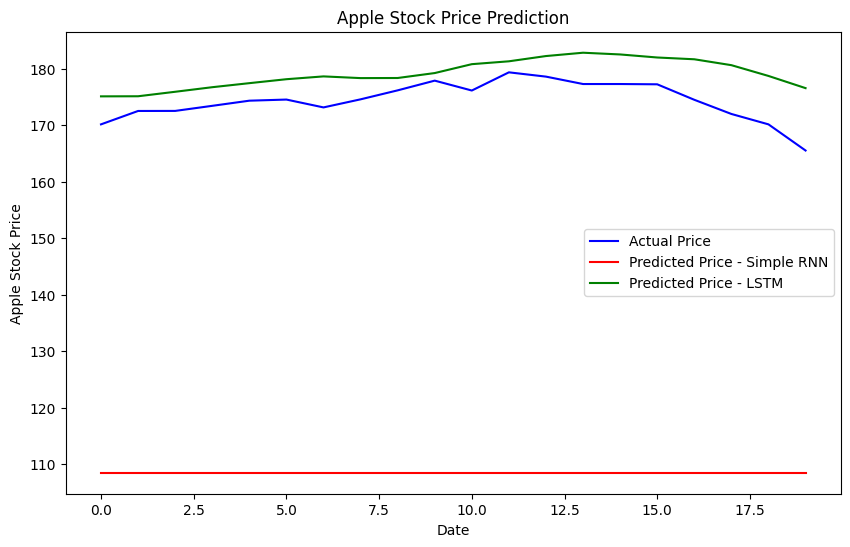

In [139]:
plt.figure(figsize=(10,6))
plt.plot(df_test, color='blue', label='Actual Price')
plt.plot(y_pred_SimpleRNN , color='red', label='Predicted Price - Simple RNN')
plt.plot(y_pred_LSTM , color='green', label='Predicted Price - LSTM')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()